<a href="https://colab.research.google.com/github/kk890528/python-work/blob/master/%E6%94%BF%E5%A4%A7pyday%E5%AF%A6%E4%BD%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/tjwei/nccu_pyday_2020

Cloning into 'nccu_pyday_2020'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 120 (delta 16), reused 112 (delta 12), pack-reused 0
Receiving objects: 100% (120/120), 14.64 MiB | 7.15 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [0]:
!mv nccu_pyday_2020/deap/* 

mv: cannot stat 'nccu_pyday_2020/deap/*': No such file or directory


In [0]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving IMG_2474.JPG to IMG_2474.JPG
User uploaded file "IMG_2474.JPG" with length 327682 bytes


In [0]:
ls

nccu_pyday_2020/  sample_data/


In [0]:
SIZE_X, SIZE_Y = 256, 256
NUMBER_OF_TRIANGLES = 50
POPULATION = 50
NGEN = 4000
POLY = 3

In [0]:
import multiprocessing
from deap import base, creator, tools, algorithms
from PIL import Image, ImageDraw
from random import randint
import skimage

In [0]:
!pip install deap

     |████████████████████████████████| 163kB 2.6MB/s 


In [0]:
def gen_one_triangle():
    return (tuple([(randint(0, SIZE_X), randint(0, SIZE_Y)) for i in range(POLY)]),
            randint(0,255), randint(0,255), randint(0,255), randint(0,255))

In [0]:
creator.create("Fitness", base.Fitness, weights=(1.0,))  # maximize fitness
creator.create("Individual", list, fitness=creator.Fitness)  # individual class

toolbox = base.Toolbox()
toolbox.register("attr", gen_one_triangle)  # the above function
toolbox.register("individual", tools.initRepeat,  # initialization of individual
                 creator.Individual, toolbox.attr, NUMBER_OF_TRIANGLES)
toolbox.register("population", tools.initRepeat,  # initialization of population
                 list, toolbox.individual)

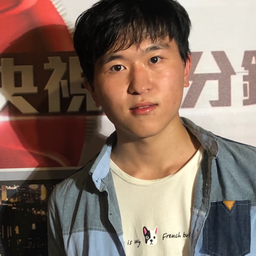

In [0]:
import numpy as np
target_im = Image.open("IMG_2474.JPG").crop((0,100,800,900)).resize((256,256), Image.LANCZOS)
target_array = np.array(target_im, dtype='float')/255.
target_im

In [0]:
def triangles_to_image(triangles):
    im = Image.new('RGB', (SIZE_X, SIZE_Y), (0, 0, 0))
    for tri in triangles:
        mask = Image.new('RGBA', (SIZE_X, SIZE_Y))
        draw = ImageDraw.Draw(mask)
        draw.polygon(tri[0], fill=tri[1:])
        im.paste(mask, mask=mask)
        del mask, draw
    return im

def evaluate(t2):
    output_im = triangles_to_image(t2)
    output_array = np.array(output_im, dtype='float')/255.
    #score = skimage.measure.compare_psnr(output_array, target_array, 1.)
    score=1-np.mean((output_array-target_array)**2)
    #score = skimage.measure.compare_ssim(output_array, target_array, data_range=1., multichannel=True)
    return (score,)

In [0]:
def mutate(triangles):
    e0 = triangles.fitness.values
    for i in range(10):
        tid = randint(0, NUMBER_OF_TRIANGLES - 1)
        oldt = triangles[tid]

        p = randint(-1, 2 * POLY + 4 - 1)
        if p == -1:
            tid2 = randint(0, NUMBER_OF_TRIANGLES - 1)
            triangles[tid], triangles[tid2] = triangles[tid2], oldt
        else:
            t = list(oldt)
            if p < 2 * POLY:
                points = list(t[0])
                pnt = list(points[p // 2])
                if p%2 == 0:
                    pnt[0] = randint(0, SIZE_X)
                else:
                    pnt[1] = randint(0, SIZE_Y)
                points[p // 2] = tuple(pnt)
                t[0] = tuple(points)
            else:
                p -= 2 * POLY - 1
                t[p] = randint(0, 255)

            triangles[tid] = tuple(t)
   
        if evaluate(triangles) > e0:
            break
        else:
            if p == -1:
                triangles[tid], triangles[tid2] = oldt, triangles[tid]
            else:
                triangles[tid] = oldt
    return [triangles]

In [0]:
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)  # crossover
toolbox.register("mutate", mutate)  # mutation
toolbox.register("select", tools.selTournament, tournsize=3)

In [0]:
from IPython.display import display, clear_output
import numpy as np
class ipyHOF(tools.HallOfFame):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.last_displayed_fitness = -1
    def insert(self, item):
        if item.fitness.values[0] >= self.last_displayed_fitness+0.001:
            self.last_displayed_fitness = item.fitness.values[0]
            clear_output(True)
            display(triangles_to_image(item))        
        super().insert(item)

In [0]:
pop = toolbox.population(n=POPULATION)
hof = ipyHOF(3)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("std", np.std)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)

# For multiprocessing
pool = multiprocessing.Pool()
toolbox.register("map", pool.map)

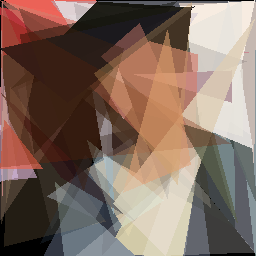

3482	24    	8.93872e-05	0.983207	0.9826  	0.982438
3483	28    	0.000284046	0.982613	0.98254 	0.98068 
3484	32    	4.46191e-05	0.982613	0.982589	0.982281
3485	34    	0.000712187	0.982613	0.982453	0.977671
3486	23    	0.000158787	0.982618	0.98257 	0.981769
3487	25    	0.000392601	0.982618	0.982522	0.980125
3488	24    	1.16998e-05	0.982618	0.982612	0.982536
3489	22    	0.000227991	0.982618	0.982574	0.981049
3490	32    	0.000335605	0.982618	0.982532	0.980435
3491	19    	0.000308584	0.982618	0.982551	0.981013
3492	32    	3.01565e-06	0.982618	0.982617	0.982596
3493	27    	4.45336e-05	0.982622	0.982607	0.982382
3494	31    	0.000137522	0.982622	0.982587	0.981883
3495	20    	4.61546e-05	0.982622	0.982607	0.982381
3496	27    	0.000107891	0.982623	0.982597	0.98204 
3497	18    	1.03572e-06	0.982623	0.982622	0.982618
3498	28    	2.09426e-06	0.982623	0.982622	0.982607
3499	24    	4.73363e-05	0.982623	0.982616	0.982284
3500	23    	0.00016372 	0.982623	0.982595	0.981458
3501	23    	2.19955e-07	0.98262

In [0]:
try:
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=NGEN, 
                               stats=stats, halloffame=hof, verbose=True)
except KeyboardInterrupt:
    display(triangles_to_image(hof[0]))

In [0]:
img1 = triangles_to_image(hof[0])
img2 = Image.open("IMG_2474.JPG")

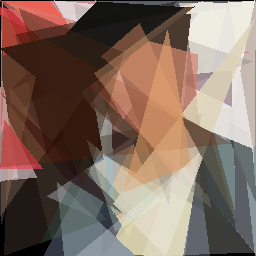

In [0]:
display(triangles_to_image(hof[0]))

In [0]:
triangles_to_image(hof[0]).save('照片.png')

In [0]:
img3 = np.clip((np.array(img1, dtype='float')+np.array(img2, dtype='float'))/2, 0, 255)
img3 = Image.fromarray(img3.astype('uint8'))

ValueError: ignored

In [0]:
ls

drive/  IMG_2474.JPG  sample_data/  照片.JPG  照片.png


In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! clone /content/drive

/bin/bash: clone: command not found
